In [1]:
# Path setup
import sys
import os

sys.path.append("/home/dchen/Random_Forest_Weights/")

# Basics:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Helpful:
from sklearn.model_selection import train_test_split

# Pipeline and ColumnsTransformer:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# models:
import statsmodels.api as sm

# my functions:
from src_rf.methods.calc_mean import *
from src_rf.methods.calc_weights import *
from src_rf.methods.calc_dist import *
from src_rf.datasets.load_weights_energy import * 
from src_rf.methods.filter_weights_rf import * 

### 0. Setup

In [2]:
def quantile_loss(y_true, y_pred, tau):
    return max(tau * (y_true - y_pred), (1 - tau) * (y_pred - y_true))

In [3]:
quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]

### 1. Load Data and train test split

In [4]:
df = pd.read_csv("/home/dchen/Random_Forest_Weights/src_rf/data/energy_data_hourly.csv"
                 , index_col = 'datetime', parse_dates=True)

In [5]:
X = df.drop('total_energy_usage', axis = 1)
y = df['total_energy_usage']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3 ,shuffle=False, random_state=42)

In [14]:
X_train

,residual_energy_usage,pump_storage,hour,month,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
datetime,,,,,,,,,,,
2015-01-01 00:00:00,35.957,602.0,0,1,0,0,0,0,1,0,0
2015-01-01 01:00:00,34.642,347.0,1,1,0,0,0,0,1,0,0
2015-01-01 02:00:00,32.910,522.0,2,1,0,0,0,0,1,0,0
2015-01-01 03:00:00,31.548,1229.0,3,1,0,0,0,0,1,0,0
2015-01-01 04:00:00,30.775,1821.0,4,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2020-06-11 11:00:00,33.839,16.0,11,6,0,0,0,0,1,0,0
2020-06-11 12:00:00,32.387,123.0,12,6,0,0,0,0,1,0,0
2020-06-11 13:00:00,29.454,475.0,13,6,0,0,0,0,1,0,0


### 2. Load Random Forest Weights

In [7]:
rf_weights = load_weights_energy()

### 3. Explore Weights

In [76]:
X_test.shape

(20456, 11)

In [77]:
test_date = 20450

In [78]:
rf_weight_0 = filter_weight_rf(rf_weights , test_date)

In [79]:
rf_weight_0.sum()

1.0

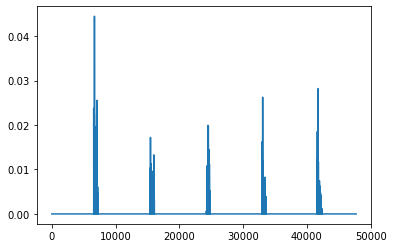

In [80]:
plt.plot(rf_weight_0)
plt.show()

In [94]:
non_zeros =  np.where(rf_weight_0 != 0)[0]

In [95]:
non_zeros.shape

(243,)

In [96]:
X_test.iloc[test_date]

residual_energy_usage    57.269
pump_storage             10.000
hour                     18.000
month                    10.000
Friday                    0.000
Monday                    0.000
Saturday                  0.000
Sunday                    0.000
Thursday                  0.000
Tuesday                   1.000
Wednesday                 0.000
Name: 2022-10-11 18:00:00, dtype: float64

In [97]:
print('month')
X_train.iloc[non_zeros, : ]['month'].value_counts()

month


10    243
Name: month, dtype: int64

In [98]:
print('Week day:')
X_train.iloc[non_zeros, :][['Friday','Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']].sum()

Week day:


Friday       32
Monday       40
Saturday      0
Sunday        0
Thursday     48
Tuesday      80
Wednesday    43
dtype: int64

In [99]:
print('hour')
X_train.iloc[non_zeros, :]['hour'].value_counts()

hour


18    76
19    58
17    40
20    24
16    23
15    18
14     4
Name: hour, dtype: int64

In [100]:
X_train.iloc[non_zeros, :][['month', 'Friday','Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'hour']]

,month,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,hour
datetime,,,,,,,,,
2015-10-01 18:00:00,10,0,0,0,0,1,0,0,18
2015-10-01 20:00:00,10,0,0,0,0,1,0,0,20
2015-10-02 18:00:00,10,1,0,0,0,0,0,0,18
2015-10-02 19:00:00,10,1,0,0,0,0,0,0,19
2015-10-02 20:00:00,10,1,0,0,0,0,0,0,20
...,...,...,...,...,...,...,...,...,...
2019-10-29 18:00:00,10,0,0,0,0,0,1,0,18
2019-10-29 19:00:00,10,0,0,0,0,0,1,0,19
2019-10-29 20:00:00,10,0,0,0,0,0,1,0,20


In [91]:
X_train.iloc[non_zeros,:].index

DatetimeIndex(['2015-05-09 20:00:00', '2015-05-16 20:00:00',
               '2015-05-23 20:00:00', '2015-05-30 20:00:00',
               '2015-06-06 20:00:00', '2015-06-13 20:00:00',
               '2015-06-20 20:00:00', '2015-06-27 20:00:00',
               '2015-07-04 20:00:00', '2015-07-11 20:00:00',
               ...
               '2020-04-11 20:00:00', '2020-04-18 20:00:00',
               '2020-04-25 20:00:00', '2020-05-02 20:00:00',
               '2020-05-09 20:00:00', '2020-05-16 20:00:00',
               '2020-05-16 21:00:00', '2020-05-23 20:00:00',
               '2020-05-30 20:00:00', '2020-06-06 20:00:00'],
              dtype='datetime64[ns]', name='datetime', length=103, freq=None)

In [101]:
rf

NameError: name 'rf' is not defined